<a href="https://colab.research.google.com/github/anushayerram2025/AIML/blob/main/Copy_of_AIML_Module_1_Lab_3_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

In [ ]:
"""
here train_x is training images and train_y is training labels..and test_x is testing images and test_y is the labels for that testing images
these images are divided by 255 to bring the pixel in range [0,1] so that it becomes easy for neural network to learn from data
train_X = train_X[::1200,:,:].copy(): This line selects every 1200th image from the original training data and stores it in train_X.
The .copy() function is used to create a new copy of the selected data to avoid modifying the original data.
train_y = train_y[::1200].copy(): Similarly, this line selects every 1200th label from the original training labels and stores it in train_y.
Again, .copy() is used to create a new copy of the selected labels.
The reason for this subsampling can vary depending on the context and goals of the machine learning task.
Subsampling can be useful for various reasons, such as reducing training time when dealing with a large dataset or creating a smaller dataset for experimentation and testing.
However, it's important to note that by subsampling, you are reducing the amount of training data, which can impact the model's performance.
The choice of subsampling rate (in this case, 1200) depends on the specific requirements of the task and should be chosen carefully to balance computational efficiency and model accuracy.
"""

Let us borrow a few functions from the previous labs:

In [11]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label
#NN1 function here calculates the distance between the query point and all training data points, selects the nearest neighbor,
#..and assigns its label as the predicted label for the query point.
def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # ..and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  #reshape the training and test data to flatten the 28x28 pixel images into one-dimensional arrays.
  #..This is a common preprocessing step.
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  #For each data point in the test set, it calls the NN1 function to predict its label using the training data.
  #.. The predicted labels for all test data points are collected in the predlabel array.
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)
"""
function calculates the accuracy of the K-nearest neighbors classifier by comparing the ground truth labels (gtlabel) with the predicted labels (predlabel).
"""

'\nfunction calculates the accuracy of the K-nearest neighbors classifier by comparing the ground truth labels (gtlabel) with the predicted labels (predlabel).\n'

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [6]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

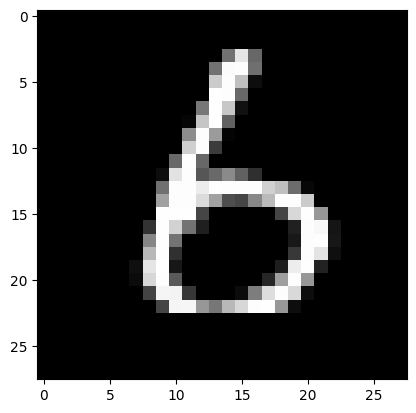

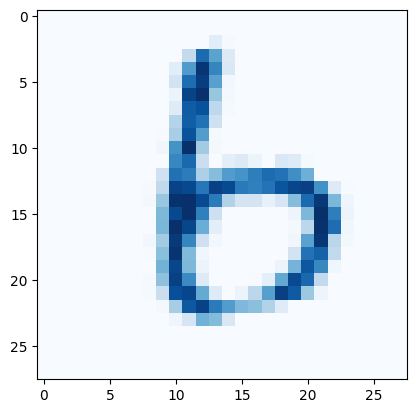

In [7]:
plt.imshow(train_X[4], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[4],15), cmap='Blues')

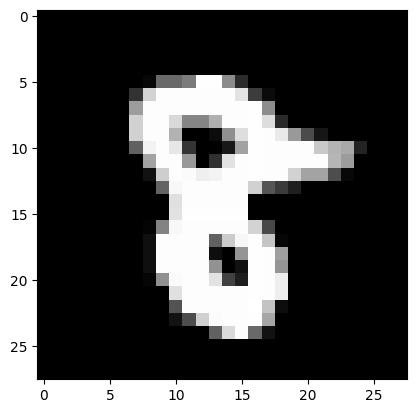

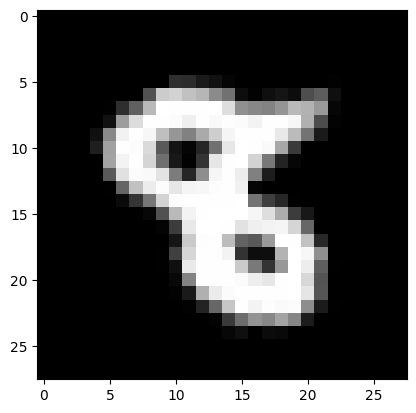

In [8]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [9]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

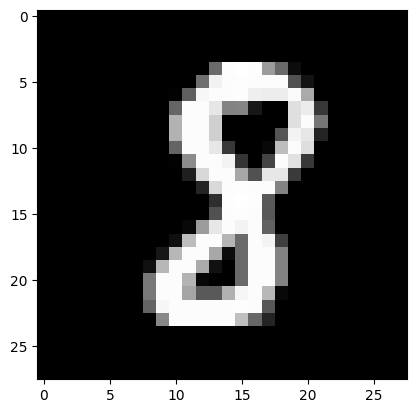

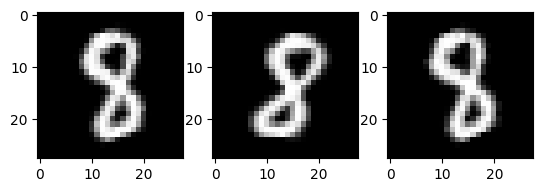

In [10]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [11]:
# hyperparameters
angleconstraint = 10 #This variable represents an angle constraint, indicating the maximum angle by which the images can be rotated during data augmentation.
naugmentations = 5 #This variable specifies the number of augmentations to perform on the training data.


# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6676


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [13]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-13-2f14d3721156>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6594
Accuracy after rotation augmentation constrained by  20  is  0.6798
Accuracy after rotation augmentation constrained by  30  is  0.6771
Accuracy after rotation augmentation constrained by  40  is  0.6797
Accuracy after rotation augmentation constrained by  50  is  0.6772
Accuracy after rotation augmentation constrained by  60  is  0.6691
Accuracy after rotation augmentation constrained by  70  is  0.6603
Accuracy after rotation augmentation constrained by  80  is  0.6518
Accuracy after rotation augmentation constrained by  90  is  0.652


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

In [ ]:
#The validation set is used to fine-tune the model's hyperparameters and monitor its performance during training.

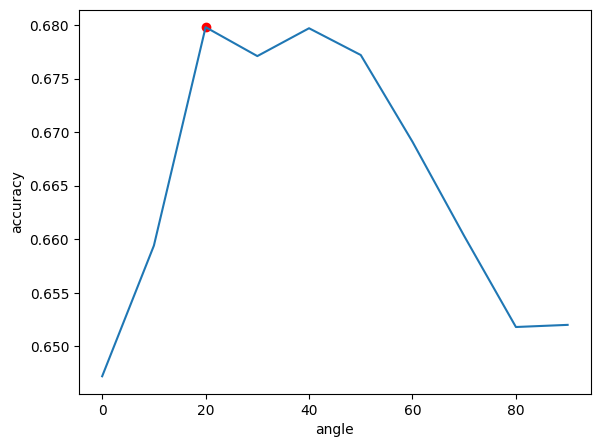

In [14]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [15]:
def shear(sample, amount):
  #amount is the shear angle
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  #it calculates the horizontal (xshift) and vertical (yshift) shifts required to re-center the sheared image.
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  #col and row gives the parts of the sheared image with content.
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

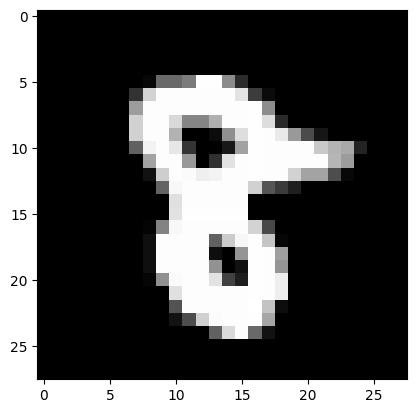

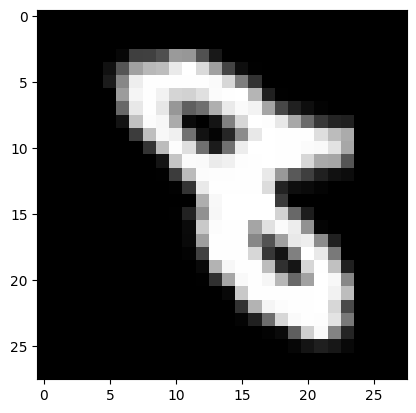

In [16]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

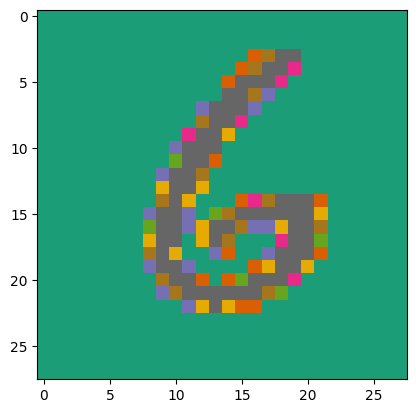

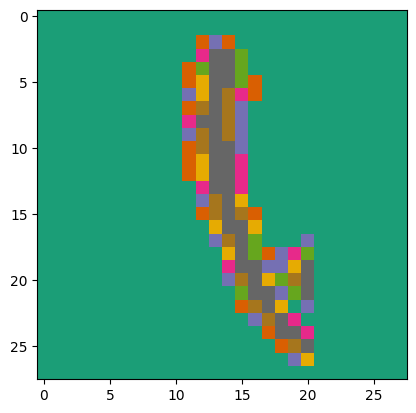

In [17]:
sample = train_X[5]
plt.imshow(sample, cmap='Dark2')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.7), cmap='Dark2')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [18]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [19]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-19-8a89fef4983d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6129
Accuracy after shear augmentation constrained by  0.4  is  0.6258
Accuracy after shear augmentation constrained by  0.6  is  0.6467
Accuracy after shear augmentation constrained by  0.8  is  0.6482
Accuracy after shear augmentation constrained by  1.0  is  0.6375
Accuracy after shear augmentation constrained by  1.2  is  0.6428
Accuracy after shear augmentation constrained by  1.4  is  0.6274
Accuracy after shear augmentation constrained by  1.6  is  0.6525
Accuracy after shear augmentation constrained by  1.8  is  0.6397
Accuracy after shear augmentation constrained by  2.0  is  0.6225


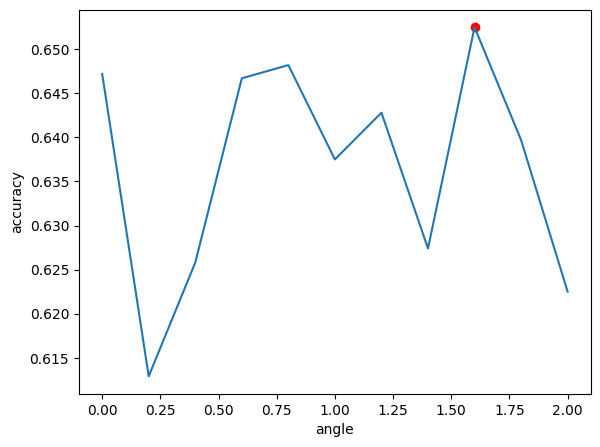

In [20]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    #why it is neccessary that the data to be three dimension..How DOES dimenision of dataset plays a role???????????????????????????????????
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample...(okay but what is the problem with it..???????????????)

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-31-09de780976d0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.5874
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6078
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5953
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6135
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.5979
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5841
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6336
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6134
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6258
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6168
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.62
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.5933
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.598
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6349
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.588

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

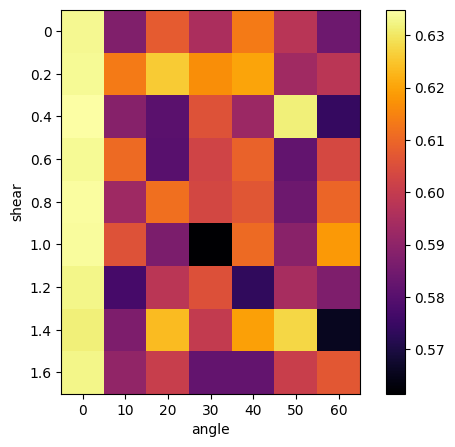

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
#'inferno' is used, which is a perceptually uniform colormap suitable for visualizing numerical data.
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)
"""
Darker cells represent higher accuracy values.
Lighter cells represent lower accuracy values.
"""

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

In [ ]:
"""
1) shear constraint -->0.8,angle constraint-->around 40 and the increase in accuracy is around 1.03 times but I don't think these values are constant..everytime we run the code..we get different accuracies and that's normal.
2) slight increase in no.of augmentations (at small rate) will definetly help in increasing accuracy but too many augmentations can't disrupt the actual image and mislead.


"""

In [ ]:
#Flipping Images, translate (change position ), adding Noise (unwanted info or features), Blurring images, croppping, filters,are different ways of augmentation
#In general, To make dataset big..such that It helps model to learn we have to use all the above augmentation ways including scaling and rotation
# then model will learn the data in all scenarios of the dataset and increases the accuracy to classy the unseen test data.

Text(0.5, 1.0, 'Left to Right Flipped')

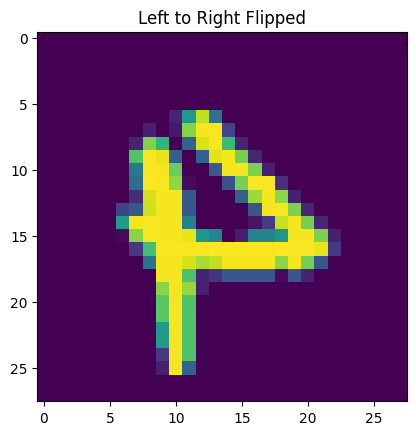

In [27]:
#Flipping Images..(here I will continue to consider the numbers).. I will consider 4,2,5 numbers on which flipping differs from the original number.
image=train_X[15]
flipLR = np.fliplr(image)
plt.imshow(flipLR)
plt.title('Left to Right Flipped')

Text(0.5, 1.0, 'Left to Right Flipped')

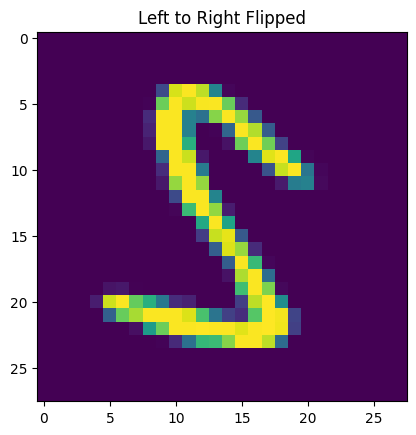

In [29]:
image=train_X[19]
flipLR = np.fliplr(image)
plt.imshow(flipLR)
plt.title('Left to Right Flipped')

Text(0.5, 1.0, 'Left to Right Flipped')

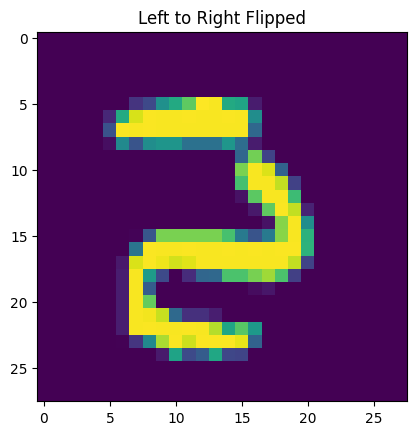

In [33]:
image=train_X[29]
flipLR = np.fliplr(image)
plt.imshow(flipLR)
plt.title('Left to Right Flipped')

In [34]:
#adding Noise

Text(0.5, 1.0, 'Random Noise to digit 6')

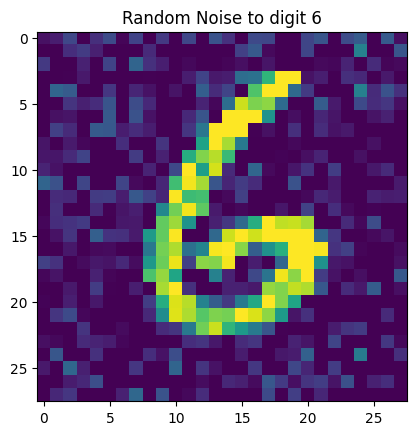

In [7]:
from skimage.util import random_noise
image=train_X[5]
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(image,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise to digit 6')

Text(0.5, 1.0, 'Random Noise')

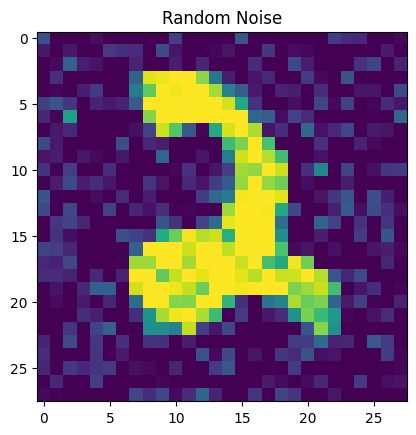

In [38]:
image=train_X[8]
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(image,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise to digit 2')

In [39]:
#flipping and adding noise
def flipNoise(image):
    flipLR = np.fliplr(image)
    sigma=0.155
    #add random noise to the image
    noisyRandom = random_noise(flipLR,var=sigma**2)

    plt.imshow(noisyRandom)
    plt.title('flipNoise')


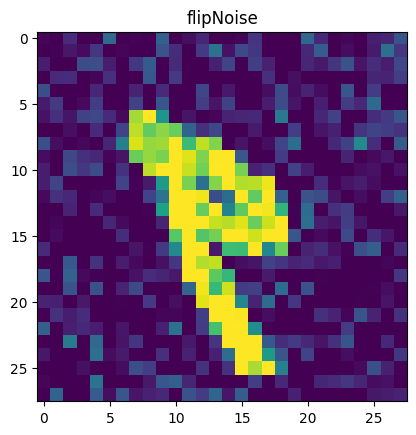

In [41]:
image=train_X[30]
flipNoise(image)
#Too blur we can't identify the number..hence this sort of augmentation is not preferred. only if it negatively doesn't affect the data then augmentations are encouraged.

In [44]:
#less noise
def flipNoise1(image,sigma):
    flipLR = np.fliplr(image)
    #add random noise to the image
    noisyRandom = random_noise(flipLR,var=sigma**2)

    plt.imshow(noisyRandom)
    plt.title('flipNoise')

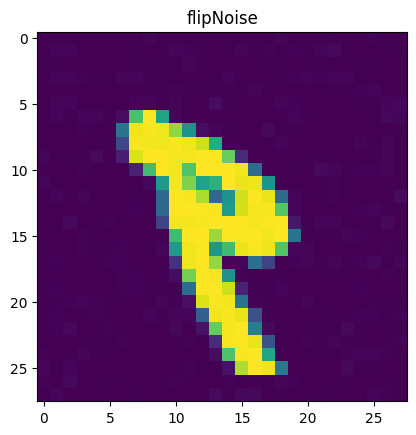

In [54]:
image=train_X[30]
flipNoise1(image,0.01)
#Now we can Identify that it is flip of 9 with slight blur without changing the figure.

In [58]:

def flipNoiseAccuracy(sample,sigma):
    new_sample=sample.copy()
    for i in range(len(sample)):
      image=sample[i]
      flipLR = np.fliplr(image)
      #add random noise to the image
      new_sample[i] = random_noise(flipLR,var=sigma**2)
    return np.squeeze(new_sample)


In [63]:
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
sigma=0.01
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, flipNoiseAccuracy(train_X, sigma))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after Flip and noise augmentation is ', Accuracy(test_y, testpred))

Accuracy after Flip and noise augmentation is  0.6217


In [61]:
#In the above I have taken the training data of size 50 train_X and did flip (left) and add noise then the accuracy is 62.2% which is greater than 50%
#Now I will apply binarySearch and try to find the minimum size of training data required to get accuracy greater than or equal to 50 , Let's try and check.
# (although it is not guaranteed that same accuracy comes the next time also..it completely depends on test data and it's new data)

In [8]:
from skimage.util import random_noise
def flipNoiseAccuracy5(sample,sigma,size):

    new_sample=sample.copy()
    for i in range(size):
      image=sample[i]
      flipLR = np.fliplr(image)
      #add random noise to the image
      new_sample[i] = random_noise(flipLR,var=sigma**2)
    return np.squeeze(new_sample)


In [13]:
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
sigma=0.01
low=1
high=len(train_X)
size=len(train_X)
while low<=high:
  mid=(low+high)//2

  augdata = np.concatenate((augdata, flipNoiseAccuracy5(train_X, sigma,mid))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracy=Accuracy(test_y, testpred)

  if accuracy<0.5:
    low=mid+1
  elif accuracy>=0.5:
    high=mid-1
    size=mid

print(f'Minimum size of training data required to get accuracy atleast 50% is {size}' )

Minimum size of training data required to get accuracy atleast 50% is 1
